# Calculate Greenspace Index for Philadelhpia
NDVI + Park Proximity + Tree Canopy Coverage

### 1. Import nessecary modules

In [3]:
import geopandas as gpd
import rasterio as rio
from rasterio.mask import mask
from rasterstats import zonal_stats
import osmnx as ox
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# After downloading the NDVI raster from the previous notebook, set the file path here
ndvi_path = "../../data/philly_ndvi_2024_summer_fixed.tif"

# Load Philadelphia boundary file
phillygdf = gpd.read_file("../../data/City_Limits.geojson")

DataSourceError: ../../data/City_Limits.geojson: No such file or directory

In [18]:
#Change CRS to match raster
phillygdf = phillygdf.to_crs("EPSG:2272")

In [22]:
# Verify the download
with rio.open(ndvi_path) as src:
    # clip to Philly boundary
    out_image, out_transform = mask(
        src,
        phillygdf.geometry,
        crop=True,
        nodata = np.nan
    )
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
        "nodata": np.nan
    })
    with rio.open("../../data/philly_ndvi_2024_summer_fixed_clipped.tif", "w", **out_meta) as dest:
        dest.write(out_image)



## 2. Census Tract Level Analysis

In [24]:
# Load Philly census tracts ACS 2022 
import pygris 
tracts = pygris.tracts(state = 'PA', county = 'Philadelphia', year = 2022)

# Change CRS to match raster
tracts = tracts.to_crs("EPSG:2272")

Using FIPS code '42' for input 'PA'
Using FIPS code '101' for input 'Philadelphia'


In [25]:
# Calculate zonal statistics for each census tract 
ndvi_stats = zonal_stats(
    tracts.geometry,
    "../../data/philly_ndvi_2024_summer_fixed_clipped.tif",
    stats=['mean', 'median', 'std', 'count'],
    nodata = np.nan
)

In [26]:
# Add stats to tracts GeoDataFrame
tracts['ndvi_mean'] = [stat['mean'] for stat in ndvi_stats]
tracts['ndvi_median'] = [stat['median'] for stat in ndvi_stats]
tracts['ndvi_std'] = [stat['std'] for stat in ndvi_stats]
tracts['ndvi_count'] = [stat['count'] for stat in ndvi_stats]

In [27]:
 # Summary statistics
print(f"\nNDVI Statistics Summary by Census Tract:")
print(tracts['ndvi_mean'].describe())
print(f"\nTracts with valid data: {(~tracts['ndvi_mean'].isna()).sum()}")
print(f"Tracts with NaN (water/no data): {tracts['ndvi_mean'].isna().sum()}")


NDVI Statistics Summary by Census Tract:
count    408.000000
mean       0.163427
std        0.068415
min        0.045760
25%        0.114874
50%        0.151343
75%        0.197715
max        0.408374
Name: ndvi_mean, dtype: float64

Tracts with valid data: 408
Tracts with NaN (water/no data): 0


### 2.1 Normalize NDVI values for easier interpretation scale (0-1)

In [28]:
tracts['ndvi_score'] = (tracts['ndvi_mean'] - 0.1) / (0.8 - 0.1)

In [30]:
# Save intermediate results
tracts.to_file('../../data/tracts_with_ndvi.geojson', driver='GeoJSON')

print(f"NDVI scores normalized to 0-1 scale")
print(f"Mean score: {tracts['ndvi_score'].mean():.3f}")


NDVI scores normalized to 0-1 scale
Mean score: 0.091


### 2.2 Let's visualize the NDVI scores across census tracts

In [40]:
import hvplot.pandas


tracts_plot = tracts.copy() # Create a copy for plotting
tracts_plot = tracts_plot.to_crs('EPSG:4326')  # Convert to lat/lon for hvplot

In [41]:
# Interactive choropleth
ndvi_map = tracts_plot.hvplot(
    c='ndvi_score',
    cmap='YlGn',
    hover_cols=['GEOID', 'ndvi_mean', 'ndvi_score'],
    tiles='CartoLight',
    alpha=0.7,
    frame_width=600,
    frame_height=500,
    title='NDVI Score by Census Tract - Philadelphia',
    clabel='NDVI Score'
)

ndvi_map

:Overlay
   .Tiles.I    :Tiles   [x,y]
   .Polygons.I :Polygons   [x,y]   (ndvi_score,GEOID,ndvi_mean)

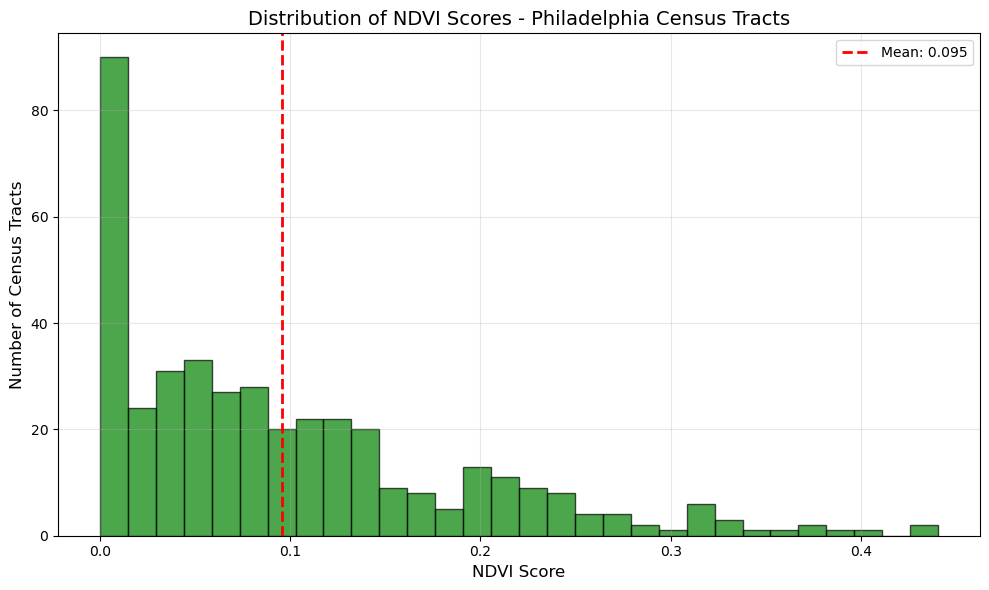

In [38]:
## Histogram
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(tracts['ndvi_score'].dropna(), bins=30, color='green', edgecolor='black', alpha=0.7)
plt.title('Distribution of NDVI Scores by Census Tract - Philadelphia')

# Add mean line
mean_ndvi = tracts['ndvi_score'].mean()
ax.axvline(mean_ndvi, color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {mean_ndvi:.3f}')
ax.set_xlabel('NDVI Score', fontsize=12)
ax.set_ylabel('Number of Census Tracts', fontsize=12)
ax.set_title('Distribution of NDVI Scores - Philadelphia Census Tracts', fontsize=14)
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../../outputs/ndvi_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

In [2]:
# Diagnostic Map
# Classify tracts into categories
def classify_ndvi(score):
    if score < 0.05:
        return 'Very Low (<0.05)'
    elif score < 0.2:
        return 'Low (0.05-0.2)'
    elif score < 0.3:
        return 'Medium (0.2-0.3)'
    elif score < 0.4:
        return 'High (0.3-0.4)'
    else:
        return 'Very High (>0.4)'

tracts['ndvi_category'] = tracts['ndvi_score'].apply(classify_ndvi)

#added by jill to re-order categoies 
scale_order = ["Very Low", "Low", "Medium", "High", "Very High"]
tracts['ndvi_category'] = pd.Categorical(tracts['ndvi_category'], categories=scale_order, ordered=True)


# Plot categories
fig, ax = plt.subplots(figsize=(12, 10))
tracts.plot(
    column='ndvi_category',
    categorical=True,
    legend=True,
    cmap='RdYlGn',
    edgecolor='black',
    linewidth=0.3,
    ax=ax,
    legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (1, 1)}
)
ax.set_title('NDVI Categories - Philadelphia Census Tracts', fontsize=16)
ax.axis('off')

plt.tight_layout()
plt.savefig('../../outputs/ndvi_categories.png', dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'tracts' is not defined

### 3. Load park data & calculate distance to neaerest park for each census tract centroid

In [48]:
# Use OSMnx to get park locations in Philadelphia
phillygdf_84 = phillygdf.to_crs("EPSG:4326")  # OSMnx requires lat/lon CRS

parks = ox.features_from_polygon(
    phillygdf_84.unary_union,
    tags={'leisure': ['park', 'playground','dog_park', 'garden', 'pitch', 'recreation_ground']}
)
# Clean up - keep only polygons (not points or lines)
parks = parks[parks.geometry.type.isin(['Polygon', 'MultiPolygon'])]


print(f"✅ Found {len(parks)} parks in Philadelphia")
print(f"   Total park area: {parks.geometry.area.sum() / 43560:.0f} acres")  # Convert sq ft to acres

# Preview
print("\nSample parks:")
print(parks[['name', 'leisure']].head(10))


# Keep only essential columns for saving
parks_clean = parks[['geometry', 'name', 'leisure']].copy()

# Handle any NaN names
parks_clean['name'] = parks_clean['name'].fillna('Unnamed Park')

# Save cleaned version
parks_clean.to_file("../../data/philadelphia_parks_osm.geojson", driver='GeoJSON')

print(f"✅ Saved {len(parks_clean)} parks to data/philadelphia_parks_osm.geojson")

# But keep the full version for analysis
print(f"\nFull parks dataset has {len(parks.columns)} columns")
print(f"Available columns: {parks.columns.tolist()[:10]}...")  # Show first 10


✅ Found 3556 parks in Philadelphia
   Total park area: 0 acres

Sample parks:
                                                 name leisure
element_type osmid                                           
way          25271691             Liberty Bell Center    park
             25430119           Jefferson Square Park    park
             25430697                Dickinson Square    park
             28311898              Liberty Lands Park    park
             28313313  Spring Garden Community Garden  garden
             28533992           Matthias Baldwin Park    park
             30286018                  Cianfrani Park    park
             32120404  Summer-Winter Community Garden  garden
             32120724   James G. Kaskey Memorial Park    park
             32121247           Clara Muhammad Square    park


C:\Users\astau\AppData\Local\Temp\ipykernel_20488\2957378581.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(f"   Total park area: {parks.geometry.area.sum() / 43560:.0f} acres")  # Convert sq ft to acres


✅ Saved 3556 parks to data/philadelphia_parks_osm.geojson

Full parks dataset has 114 columns
Available columns: ['geometry', 'ele', 'gnis:feature_id', 'leisure', 'name', 'wikidata', 'alt_name', 'sport', 'old_name', 'barrier']...


In [49]:
# ### Calculate distance to neaerest park for each census tract centroid
from scipy.spatial import cKDTree
from shapely.geometry import Point

In [51]:
# Get census tract centroids
tract_centroids = tracts.copy()
tract_centroids['geometry'] = tracts.geometry.centroid

# Get park boundaries (or centroids for small parks)
park_points = parks.geometry.representative_point()

# Build spatial index
park_coords = np.array([(p.x, p.y) for p in park_points])
tree = cKDTree(park_coords)

# Find nearest park for each census tract
tract_coords = np.array([(p.x, p.y) for p in tract_centroids.geometry])
distances, indices = tree.query(tract_coords)

# Add distance (in feet for EPSG:2272)
tracts['park_distance_ft'] = distances

### 3.1 Convert distances to proximity scores (0-1 scale)

In [52]:
# Common approach: inverse distance with maximum threshold
# 800m (1/2 mile) = ~2625 feet as maximum reasonable walking distance

max_distance_ft = 2625  # Half-mile in feet (EPSG:2272 uses feet)

tracts['park_proximity_score'] = 1 - (
    tracts['park_distance_ft'] / max_distance_ft
)

# Clip to 0-1 range (anything beyond half-mile gets score of 0)
tracts['park_proximity_score'] = tracts['park_proximity_score'].clip(0, 1)

# Alternative: Use exponential decay
# tracts['park_proximity_score'] = np.exp(-tracts['park_distance_ft'] / 1312)  # 400m in feet

### 4. Tree Canopy Raster Analysis

✅ Loaded 2,480 trees
   Columns: ['objectid', 'fcode', 'geometry']


<Axes: >

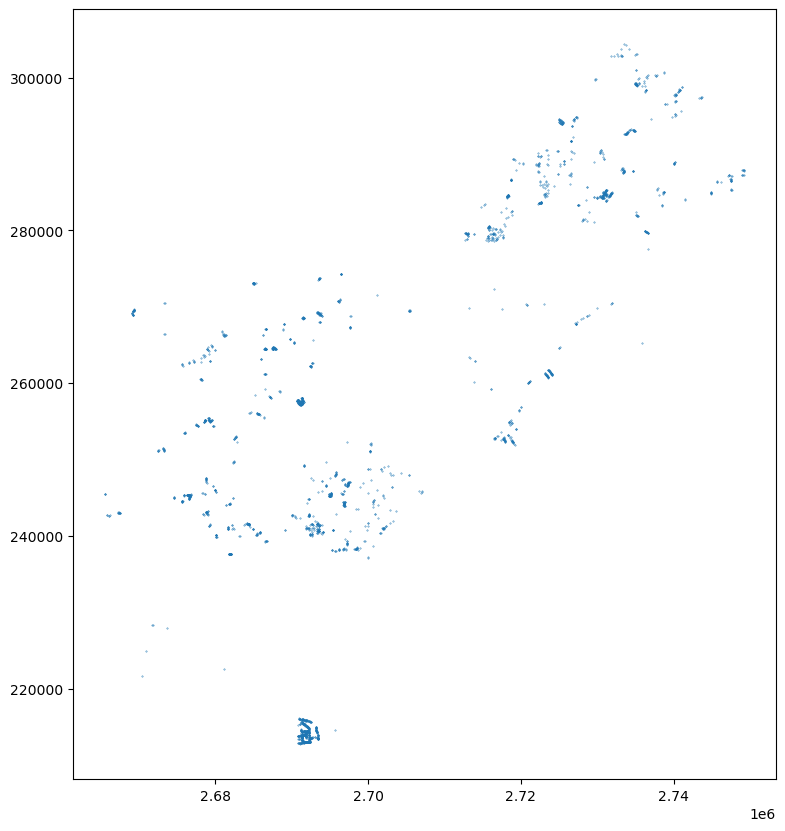

In [54]:
# Load tree point data
trees = gpd.read_file("../../data/ppr_tree_canopy_points_2015.geojson")

# Convert to EPSG:2272 to match tracts
trees = trees.to_crs('EPSG:2272')

print(f"✅ Loaded {len(trees):,} trees")
print(f"   Columns: {trees.columns.tolist()}")

# Quick check - visualize
trees.plot(markersize=0.1, figsize=(10, 10))

### 4.1 Count trees per census tract

In [55]:
# Spatial join - which tract is each tree in?
trees_with_tract = gpd.sjoin(trees, tracts[['GEOID', 'geometry']], how='left', predicate='within')

# Count trees per tract
tree_counts = trees_with_tract.groupby('GEOID').size().reset_index(name='tree_count')

# Merge back to tracts
tracts = tracts.merge(tree_counts, on='GEOID', how='left')

# Fill NaN (tracts with no trees) with 0
tracts['tree_count'] = tracts['tree_count'].fillna(0)

print(f"Trees per tract summary:")
print(tracts['tree_count'].describe())

Trees per tract summary:
count    408.000000
mean       6.078431
std       26.980906
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max      464.000000
Name: tree_count, dtype: float64


### 4.2 Calculate & Normalize Tree Density Score (0-1 scale)

In [56]:
# Option A: Trees per square mile
tracts['area_sqmi'] = tracts.geometry.area / (5280**2)  # sq ft to sq miles
tracts['tree_density'] = tracts['tree_count'] / tracts['area_sqmi']

In [58]:
# Use min-max normalization
tree_min = tracts['tree_density'].min()
tree_max = tracts['tree_density'].max()

tracts['tree_score'] = (tracts['tree_density'] - tree_min) / (tree_max - tree_min)

# Or use quantile-based (if you have outliers)
# tracts['tree_score'] = tracts['tree_density'].rank(pct=True)

print(f"Tree score range: {tracts['tree_score'].min():.3f} to {tracts['tree_score'].max():.3f}")

Tree score range: 0.000 to 1.000


## Concot Greenspace Index by combining NDVI, Park Proximity, and Tree Density Scores equal weight

In [59]:
# Now combine all three components
tracts['greenspace_index'] = (
    tracts['ndvi_score'] * 0.33 +
    tracts['park_proximity_score'] * 0.33 +
    tracts['tree_score'] * 0.34
)

### Notes

In [60]:
# Save final greenspace index
tracts.to_file("../../data/philadelphia_greenspace_index.geojson", driver='GeoJSON')

print(f"✅ Greenspace index saved!")
print(f"   Tracts: {len(tracts)}")
print(f"   Mean score: {tracts['greenspace_index'].mean():.3f}")
print(f"   Range: {tracts['greenspace_index'].min():.3f} to {tracts['greenspace_index'].max():.3f}")

✅ Greenspace index saved!
   Tracts: 408
   Mean score: 0.045
   Range: 0.000 to 0.340


In [61]:
print("="*60)
print("GREENSPACE INDEX COMPLETE")
print("="*60)
print(tracts['greenspace_index'].describe())

print(f"\nTop 5 Greenest Tracts:")
print(tracts.nlargest(5, 'greenspace_index')[['GEOID', 'greenspace_index']])

print(f"\nLeast Green Tracts:")
print(tracts.nsmallest(5, 'greenspace_index')[['GEOID', 'greenspace_index']])


GREENSPACE INDEX COMPLETE
count    408.000000
mean       0.045181
std        0.050627
min        0.000000
25%        0.010283
50%        0.030344
75%        0.064561
max        0.340000
Name: greenspace_index, dtype: float64

Top 5 Greenest Tracts:
           GEOID  greenspace_index
163  42101013300          0.340000
31   42101013402          0.299327
285  42101012203          0.297720
48   42101020500          0.262598
398  42101008702          0.224919

Least Green Tracts:
          GEOID  greenspace_index
5   42101000200               0.0
10  42101037900               0.0
11  42101038200               0.0
40  42101019200               0.0
41  42101019700               0.0
